# UNSEEN analysis


In [36]:
import os
import datetime
import glob

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import general_utils
from unseen import time_utils
from unseen import stability
from unseen import eva

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [50]:
# Parameters
metric = "rx5day"
var = "pr"
metric_plot_label = "rx5day (mm)"
metric_plot_upper_limit = 1000
obs_file = "/g/data/xv83/unseen-projects/outputs/tc-jasper/data/rx5day_AGCD-CSIRO_1901-2024_annual-aug-to-sep_daintree-river.nc"
model_file = "/g/data/xv83/unseen-projects/outputs/tc-jasper/data/rx5day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_daintree-river.nc"
model_add_bc_file = "/g/data/xv83/unseen-projects/outputs/tc-jasper/data/rx5day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_daintree-river_bias-corrected-AGCD-CSIRO-additive.nc"
model_mulc_bc_file = "/g/data/xv83/unseen-projects/outputs/tc-jasper/data/rx5day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_daintree-river_bias-corrected-AGCD-CSIRO-multiplicative.nc"
similarity_add_bc_file = "/g/data/xv83/unseen-projects/outputs/tc-jasper/data/similarity-test_rx5day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_daintree-river_bias-corrected-AGCD-CSIRO-additive.nc"
similarity_mulc_bc_file = "/g/data/xv83/unseen-projects/outputs/tc-jasper/data/similarity-test_rx5day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_daintree-river_bias-corrected-AGCD-CSIRO-multiplicative.nc"
similarity_raw_file = "/g/data/xv83/unseen-projects/outputs/tc-jasper/data/similarity-test_rx5day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_daintree-river_AGCD-CSIRO.nc"
independence_plot = "/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/independence-test_rx5day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_daintree-river.png"
stability_plot_empirical = "/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/stability-test-empirical_rx5day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_daintree-river.png"
stability_plot_gev = "/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/stability-test-gev_rx5day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_daintree-river.png"
moments_add_plot = "/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/moments-test_rx5day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_daintree-river_bias-corrected-AGCD-CSIRO-additive.png"
moments_mulc_plot = "/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/moments-test_rx5day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_daintree-river_bias-corrected-AGCD-CSIRO-multiplicative.png"
moments_raw_plot = "/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/moments-test_rx5day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_daintree-river_AGCD-CSIRO.png"
model_name = "CanESM5"
min_lead = 0
region_name = "daintree-river"
shape_file = (
    "/g/data/xv83/unseen-projects/outputs/tc-jasper/shapefiles/daintree_river.shp"
)
file_list = (
    "/g/data/xv83/unseen-projects/code/file_lists/CanESM5_dcppA-hindcast_pr_files.txt"
)


In [4]:
# Required parameters
assert 'metric' in locals(), "Must provide a metric name"
assert 'var' in locals(), "Must provide a variable name"
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert 'metric_plot_label' in locals(), "Must provide a plot axis label for the metric"
assert 'metric_plot_upper_limit' in locals(), "Must provide an upper limit for the metric value"
assert os.path.isfile(obs_file), "Must provide an observations data file (papermill option -p obs_file [filepath])"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p model_file [filepath])"
assert os.path.isfile(model_add_bc_file), "Must provide a model additive bias corrected data file (papermill option -p model_add_bc_file [filepath])"
assert os.path.isfile(model_mulc_bc_file), "Must provide a model multiplicative bias corrected data file (papermill option -p model_mulc_bc_file [filepath])"
assert os.path.isfile(similarity_add_bc_file), "Must provide an additive bias corrected similarity test file (papermill option -p similarity_add_bias_file [filepath])"
assert os.path.isfile(similarity_mulc_bc_file), "Must provide an multiplicative bias corrected similarity test file (papermill option -p similarity_mulc_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"
assert os.path.isfile(stability_plot_empirical), "Must provide an empirical stability test plot (papermill option -p stability_plot_empirical [filepath])"
assert os.path.isfile(stability_plot_gev), "Must provide a GEV stability test plot (papermill option -p stability_plot_gev [filepath])"
assert os.path.isfile(moments_add_plot), "Must provide a moments test plot for the additive bias corrected data (papermill option -p moments_add_plot [filepath])"
assert os.path.isfile(moments_mulc_plot), "Must provide a moments test plot for the multiplicative bias corrected data (papermill option -p moments_mulc_plot [filepath])"
assert os.path.isfile(moments_raw_plot), "Must provide a moments test plot for the raw data (papermill option -p moments_raw_plot [filepath])"


In [5]:
units_dict = {
    'pr': 'mm day-1'
}

## Observations

In [6]:
obs_ds = fileio.open_dataset(obs_file)
obs_ds = obs_ds.dropna('time')

In [7]:
years = obs_ds['time'].dt.year.values
obs_df = pd.DataFrame(index=years)
obs_df[var] = obs_ds[var].values

In [8]:
obs_max_event = obs_ds['pr'].values.max()
print(obs_max_event)

1459.442


## Model ensemble

### Region selection

In [9]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [10]:
first_file

'/g/data/oi10/replicas/CMIP6/DCPP/CCCma/CanESM5/dcppA-hindcast/s1960-r1i1p2f1/day/pr/gn/v20190429/pr_day_CanESM5_dcppA-hindcast_s1960-r1i1p2f1_gn_19610101-19701231.nc'

In [11]:
shapes = gp.read_file(shape_file)

In [12]:
isel_dict = {}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/g/data/xv83/unseen-projects/code/dataset_config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [20]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=[var],
    lat_bnds=[-44, -10],
    lon_bnds=[113, 155],
#    shapefile=shape_file,
#    shape_overlap=0.001,
    units={var: units_dict[var]},
    isel=isel_dict,
)

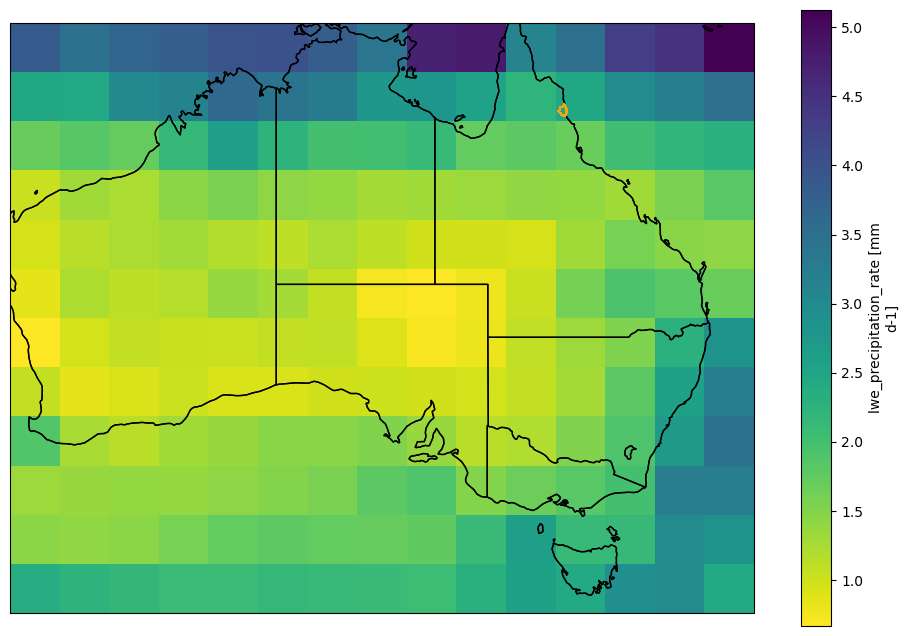

In [21]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds[var].mean('time', keep_attrs=True).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [22]:
model_ds = fileio.open_dataset(model_file)
model_add_bc_ds = fileio.open_dataset(model_add_bc_file)
model_mulc_bc_ds = fileio.open_dataset(model_mulc_bc_file)

In [23]:
model_ds

<xarray.Dataset>
Dimensions:     (init_date: 57, ensemble: 20, lead_time: 11)
Coordinates:
  * lead_time   (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    event_time  (init_date, ensemble, lead_time) object dask.array<chunksize=(57, 20, 11), meta=np.ndarray>
  * ensemble    (ensemble) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
  * init_date   (init_date) object 1961-01-01 00:00:00 ... 2017-01-01 00:00:00
    time        (lead_time, init_date) object dask.array<chunksize=(11, 57), meta=np.ndarray>
Data variables:
    pr          (init_date, ensemble, lead_time) float64 dask.array<chunksize=(57, 20, 11), meta=np.ndarray>
Attributes: (12/53)
    CCCma_model_hash:            Unknown
    CCCma_parent_runid:          d2a-asm-e01
    CCCma_pycmor_hash:           13db8596c37129e414cad7ae31f2927ca8f5dd39
    CCCma_runid:                 d2a196101e01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1961:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/f220e01c-1214-4625-be6a-c0475c2...
    variable_id:                 pr
    variant_label:               r1i1p2f1
    version:                     v20190429
    license:                     CMIP6 model data produced by The Government ...
    cmor_version:                3.4.0

### Independence testing

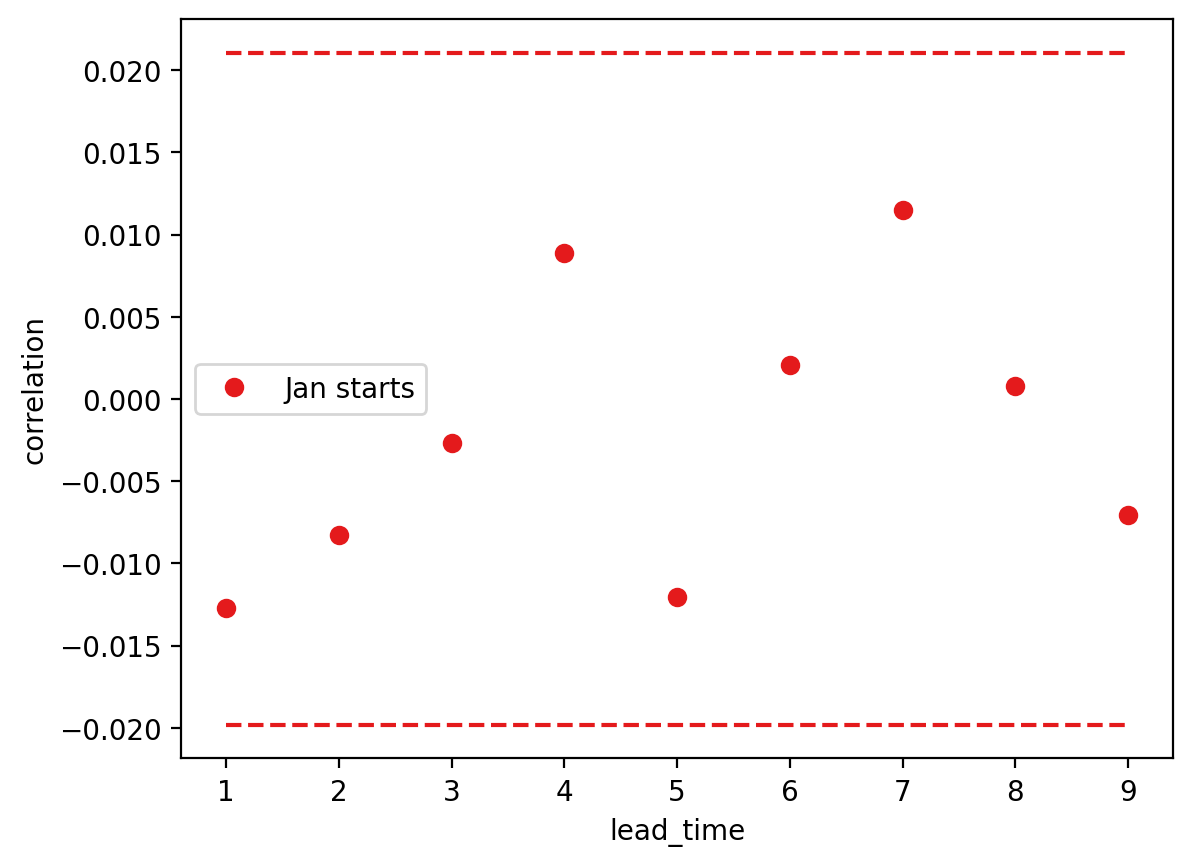

In [24]:
Image(filename=independence_plot)

In [25]:
print(min_lead)

0


In [26]:
model_da = model_ds[var].where(model_ds['lead_time'] >= min_lead)

In [27]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [28]:
model_da_stacked.shape

(10260,)

In [29]:
model_add_bc_da_stacked = model_add_bc_ds.dropna('lead_time')[var].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [30]:
model_add_bc_da_stacked.shape

(10260,)

In [31]:
model_mulc_bc_da_stacked = model_mulc_bc_ds.dropna('lead_time')[var].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [32]:
model_mulc_bc_da_stacked.shape

(10260,)

### Stability testing

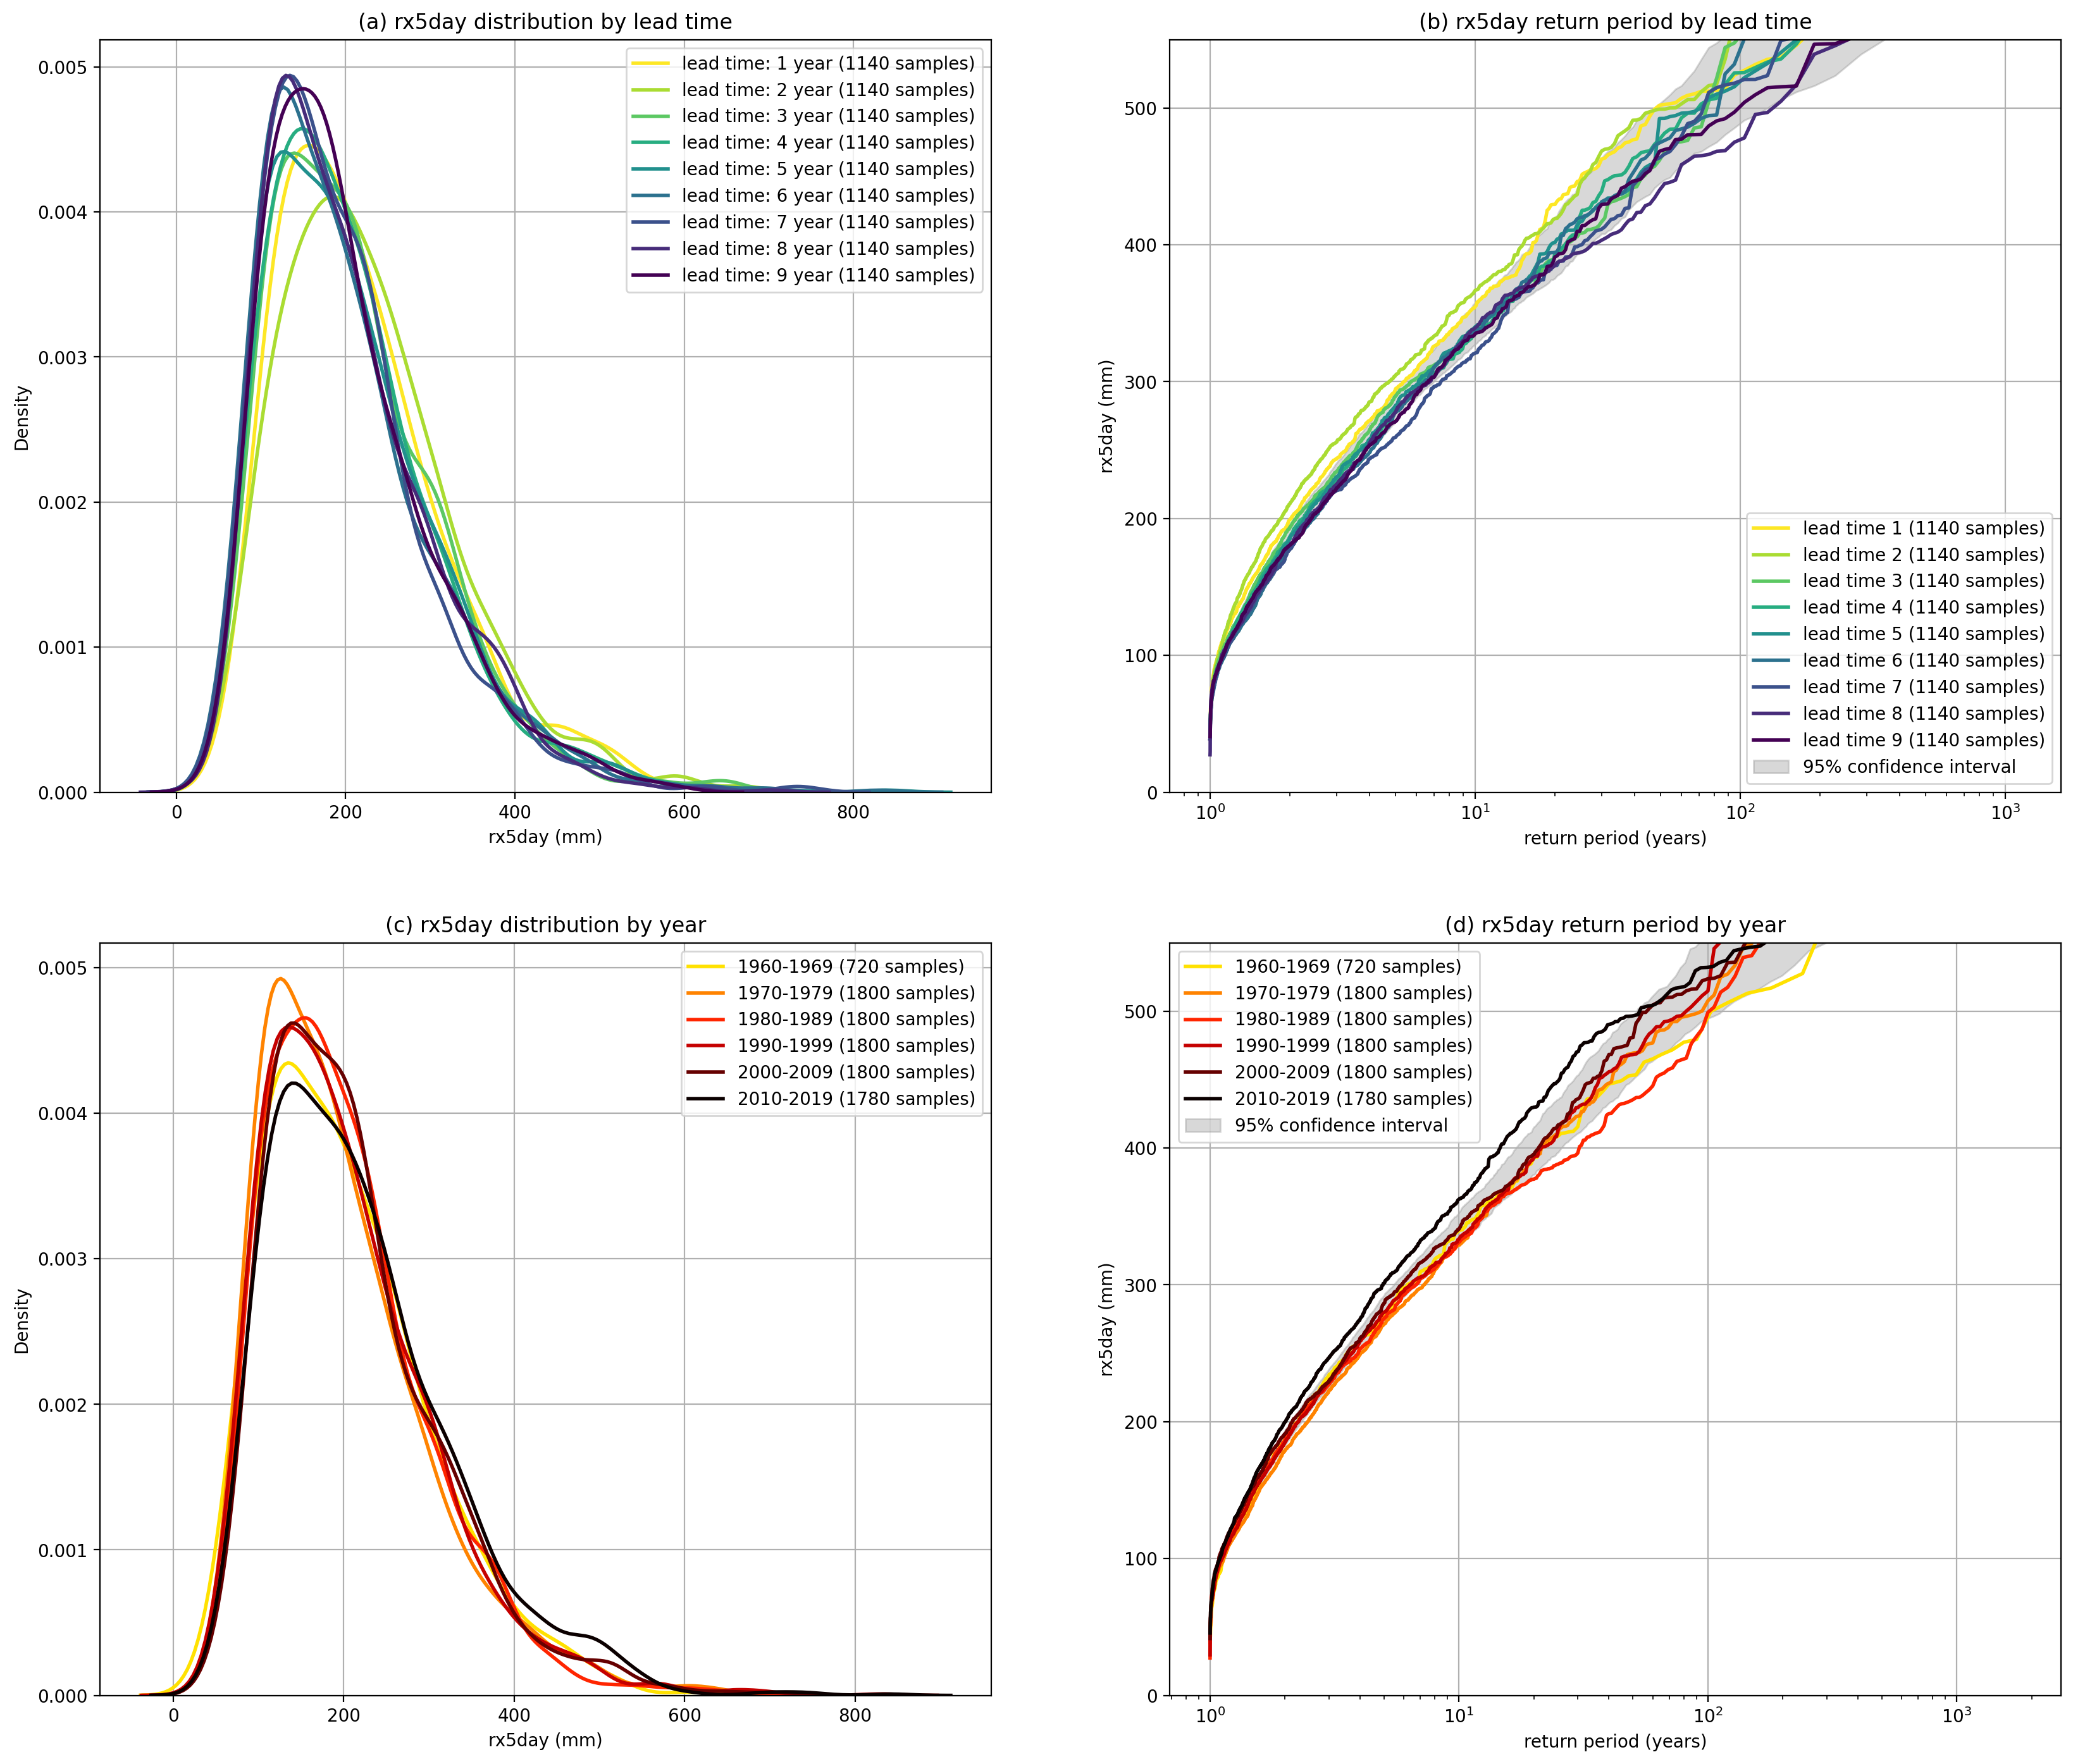

In [33]:
Image(filename=stability_plot_empirical)

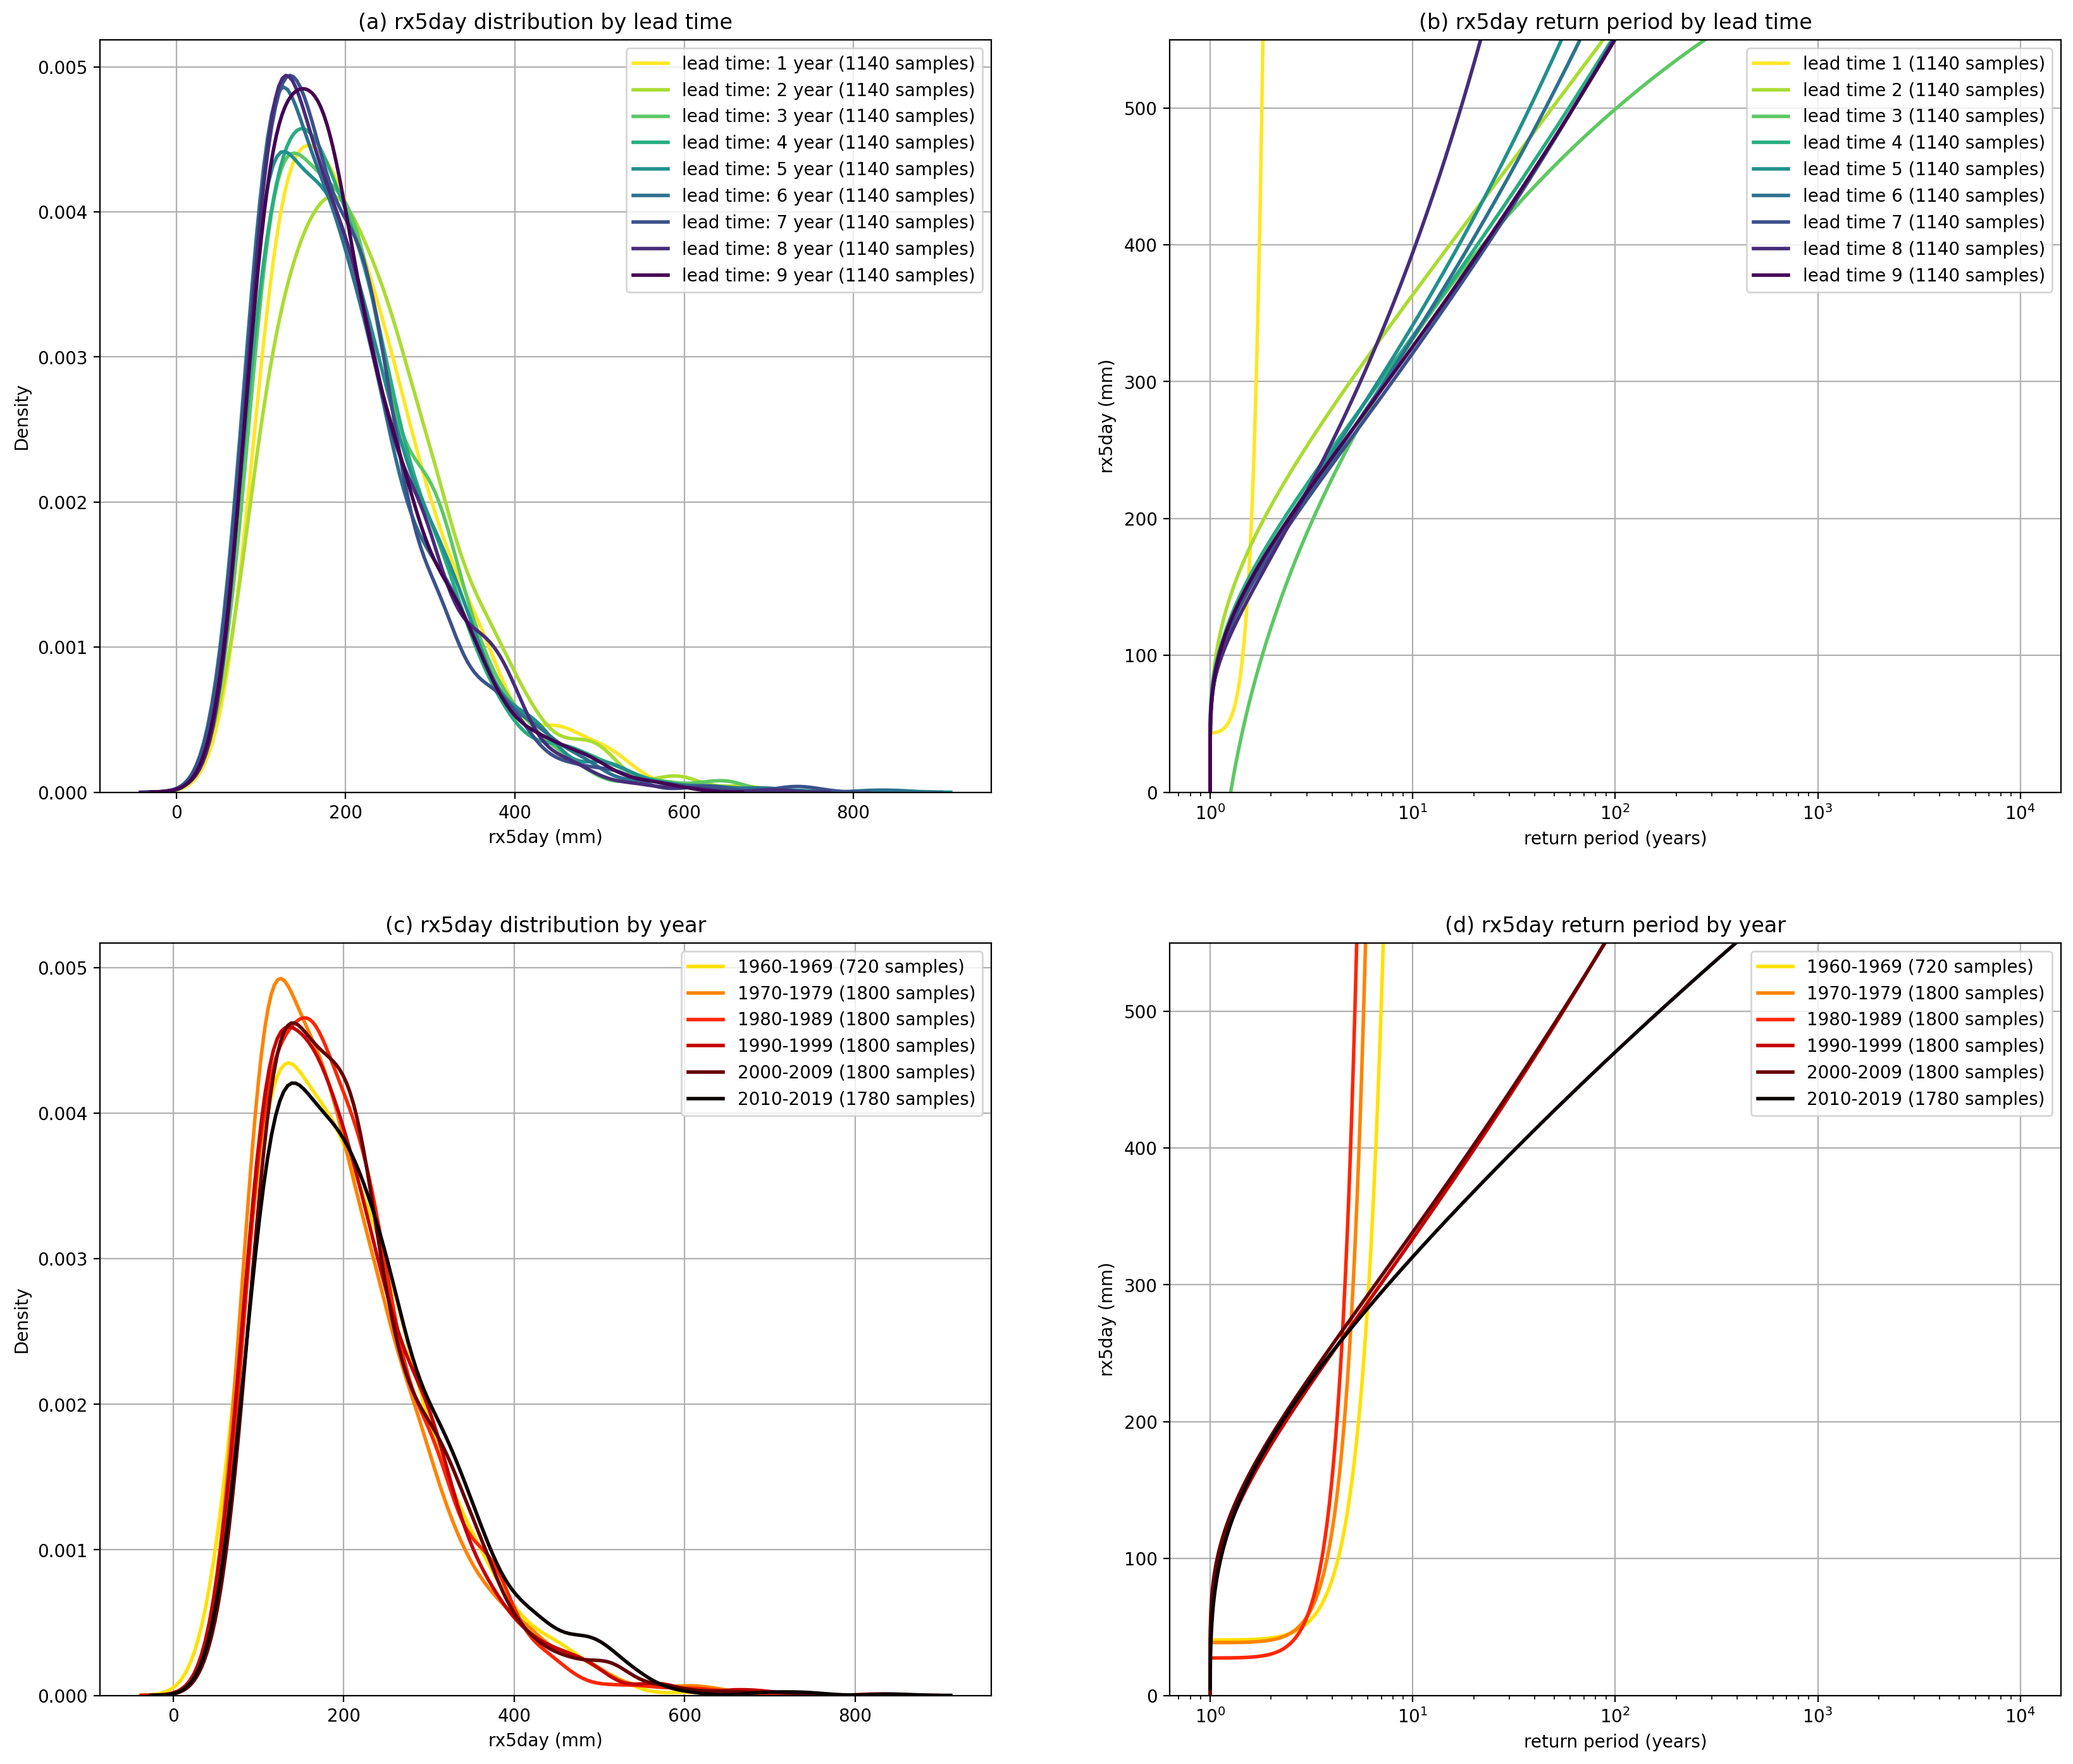

In [34]:
Image(filename=stability_plot_gev)

### Bias correction and similarity testing

In [37]:
model_gev_shape, model_gev_loc, model_gev_scale = eva.fit_gev(model_da_stacked.values)
model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale = eva.fit_gev(model_add_bc_da_stacked.values)
model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale = eva.fit_gev(model_mulc_bc_da_stacked.values)

0.0001


/home/599/dbi599/unseen/unseen/eva.py:257: UserWarning: Data fit failed. Retrying with 'generate_estimates=True'.
  warnings.warn(


0.0001


/home/599/dbi599/unseen/unseen/eva.py:263: UserWarning: Data fit failed.
  warnings.warn("Data fit failed.")


0.0001
0.0001
0.0001
0.0001


In [55]:
def plot_distributions(include_additive=False):
    """Plot various distributions"""

    fig = plt.figure(figsize=[10, 6])
    gev_xvals = np.arange(0, metric_plot_upper_limit)

    model_da.plot.hist(
        bins=50, density=True, label=model_name, alpha=0.7, facecolor='tab:blue',
    )
    model_gev_pdf = gev.pdf(gev_xvals, model_gev_shape, model_gev_loc, model_gev_scale)
    plt.plot(gev_xvals, model_gev_pdf, color='tab:blue', linewidth=4.0)

    if include_additive:
        model_add_bc_ds[var].plot.hist(
            bins=50, density=True, label=f'{model_name} additive bias corrected', facecolor='tab:red', alpha=0.7
        )
        model_add_bc_gev_pdf = gev.pdf(gev_xvals, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)
        plt.plot(gev_xvals, model_add_bc_gev_pdf, color='tab:red', linewidth=4.0)

    model_mulc_bc_ds[var].plot.hist(
        bins=50, density=True, label=f'{model_name} multiplicative bias corrected', facecolor='tab:orange', alpha=0.7
    )
    model_mulc_bc_gev_pdf = gev.pdf(gev_xvals, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)
    plt.plot(gev_xvals, model_mulc_bc_gev_pdf, color='tab:orange', linewidth=4.0)

    obs_ds[var].plot.hist(
        bins=50, density=True, label='observations', facecolor='tab:gray', alpha=0.7
    )
    obs_gev_shape, obs_gev_loc, obs_gev_scale = eva.fit_gev(obs_ds[var].values)
    obs_gev_pdf = gev.pdf(gev_xvals, obs_gev_shape, obs_gev_loc, obs_gev_scale)
#    plt.plot(gev_xvals, obs_gev_pdf, color='tab:gray', linewidth=4.0)

    plt.xlabel(metric_plot_label)
    plt.ylabel('probability')
    plt.title(f'{metric} for {region_name} ({model_name})')
    plt.xlim(0, metric_plot_upper_limit)
    plt.legend()
    #if not include_additive:
    #    outfile = f'/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/{metric}_histogram_{model_name}_{region_name}.png'
    #    print(outfile)
    #    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    plt.show()

0.0001
0.0001


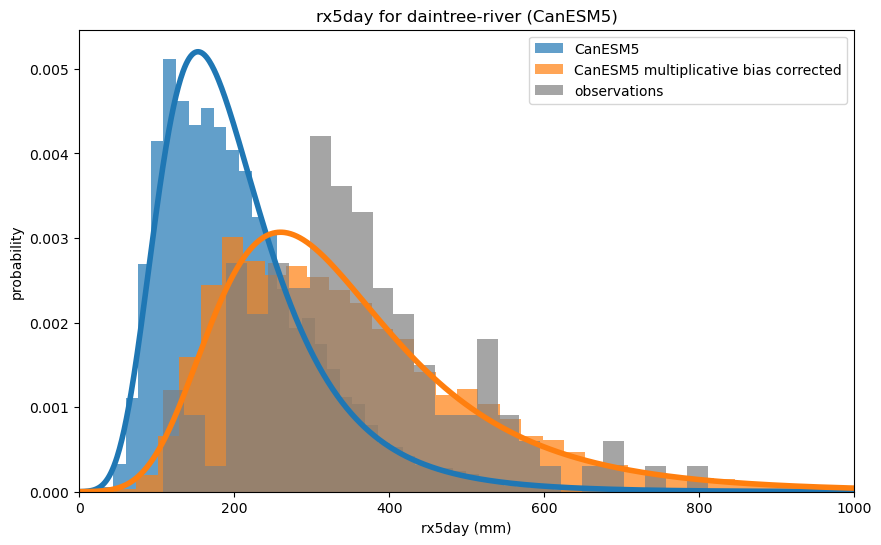

In [56]:
plot_distributions()

0.0001
0.0001


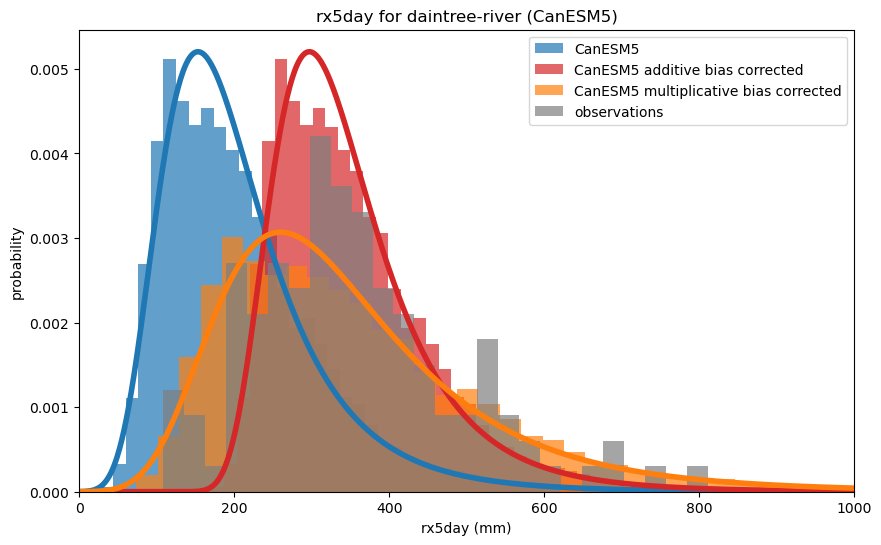

In [57]:
plot_distributions(include_additive=True)

In [58]:
print(f'raw data shape parameter: {model_gev_shape:.3f}')
print(f'raw data location parameter: {model_gev_loc:.3f}') 
print(f'raw data scale parameter: {model_gev_scale:.3f}')

raw data shape parameter: -0.092
raw data location parameter: 159.503
raw data scale parameter: 70.986


In [59]:
print(f'additive corrected shape parameter: {model_add_bc_gev_shape:.3f}')
print(f'additive corrected location parameter: {model_add_bc_gev_loc:.3f}') 
print(f'additive corrected scale parameter: {model_add_bc_gev_scale:.3f}')

additive corrected shape parameter: -0.092
additive corrected location parameter: 303.263
additive corrected scale parameter: 70.986


In [60]:
print(f'multiplicative corrected shape parameter: {model_mulc_bc_gev_shape:.3f}')
print(f'multiplicative corrected location parameter: {model_mulc_bc_gev_loc:.3f}') 
print(f'multiplicative corrected scale parameter: {model_mulc_bc_gev_scale:.3f}')

multiplicative corrected shape parameter: -0.092
multiplicative corrected location parameter: 270.451
multiplicative corrected scale parameter: 120.363


We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [61]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)

In [62]:
similarity_raw_ds['ks_statistic'].values

array(0.56530213, dtype=float32)

In [63]:
similarity_raw_ds['ks_pval'].values

array(1.0041419e-17, dtype=float32)

In [64]:
similarity_raw_ds['ad_statistic'].values

array(55.038525, dtype=float32)

In [65]:
similarity_raw_ds['ad_pval'].values

array(0.001, dtype=float32)

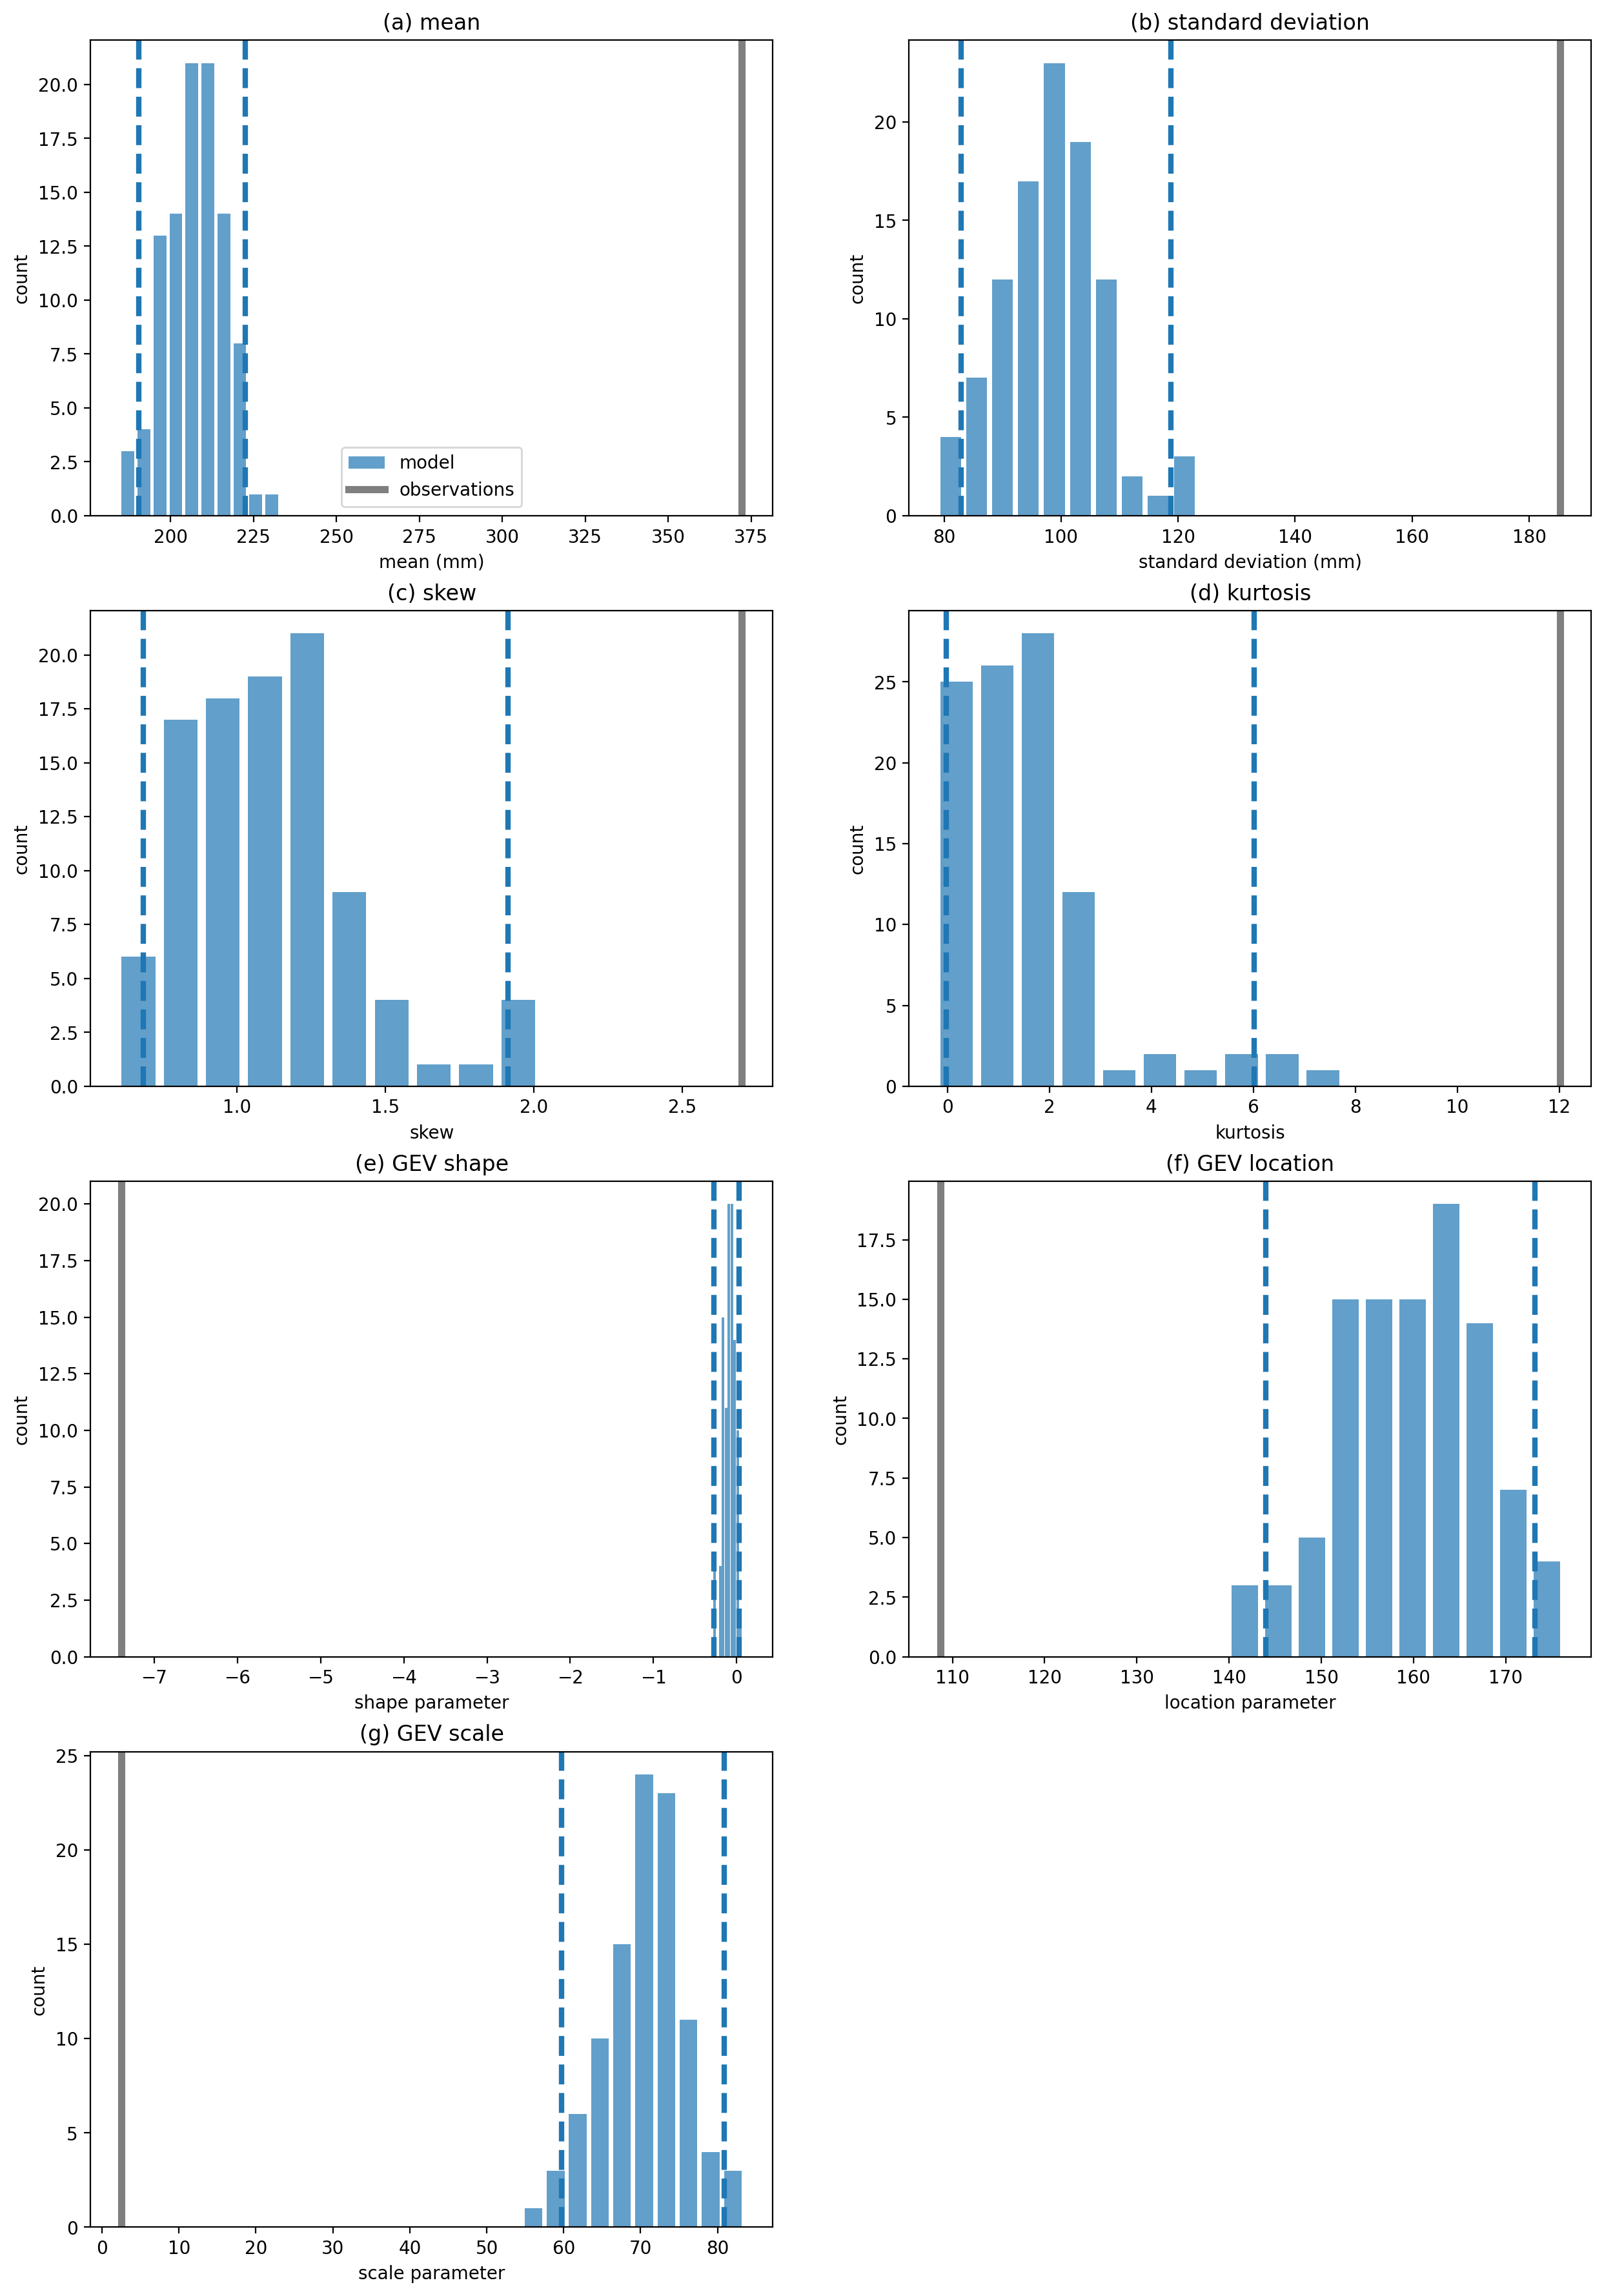

In [66]:
Image(filename=moments_raw_plot)

In [67]:
similarity_add_bias_ds = fileio.open_dataset(similarity_add_bc_file)

In [68]:
similarity_add_bias_ds['ks_statistic'].values

array(0.11130604, dtype=float32)

In [69]:
similarity_add_bias_ds['ks_pval'].values

array(0.44794148, dtype=float32)

In [70]:
similarity_add_bias_ds['ad_statistic'].values

array(2.612273, dtype=float32)

In [71]:
similarity_add_bias_ds['ad_pval'].values

array(0.02767156, dtype=float32)

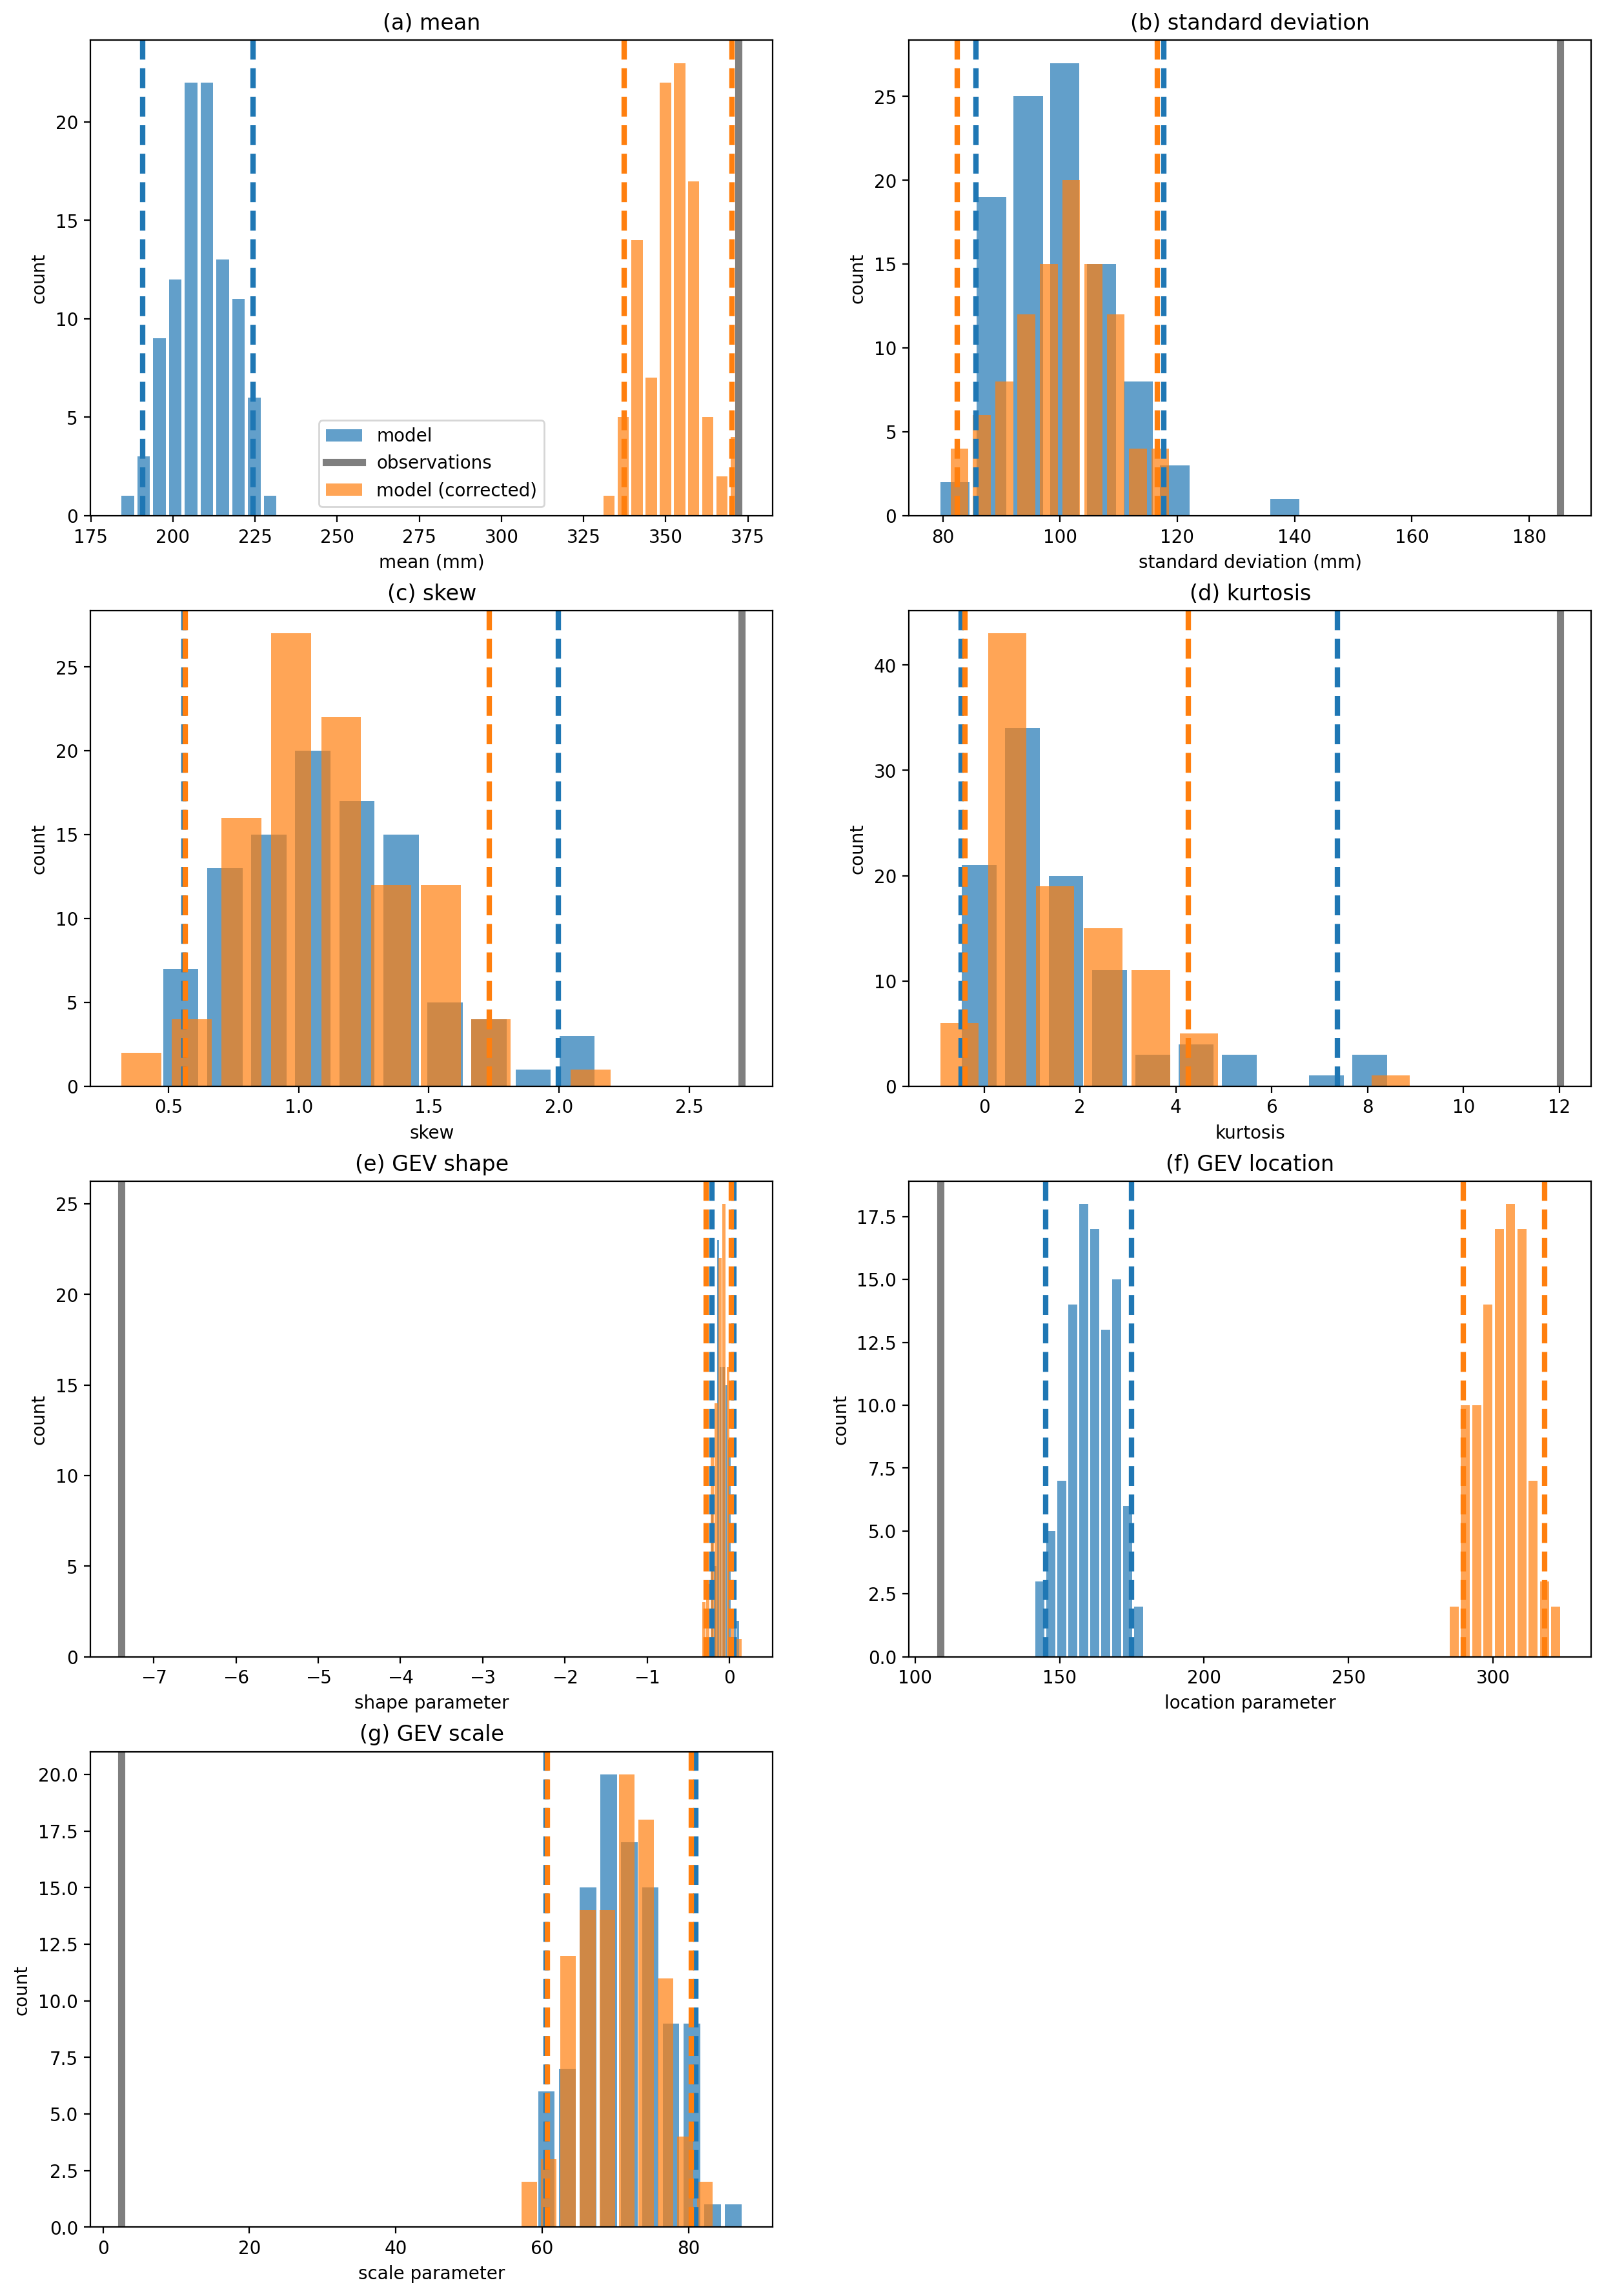

In [72]:
Image(filename=moments_add_plot)

In [73]:
similarity_mulc_bias_ds = fileio.open_dataset(similarity_mulc_bc_file)

In [74]:
similarity_mulc_bias_ds['ks_statistic'].values

array(0.16052632, dtype=float32)

In [75]:
similarity_mulc_bias_ds['ks_pval'].values

array(0.0946398, dtype=float32)

In [76]:
similarity_mulc_bias_ds['ad_statistic'].values

array(1.1729618, dtype=float32)

In [77]:
similarity_mulc_bias_ds['ad_pval'].values

array(0.10695534, dtype=float32)

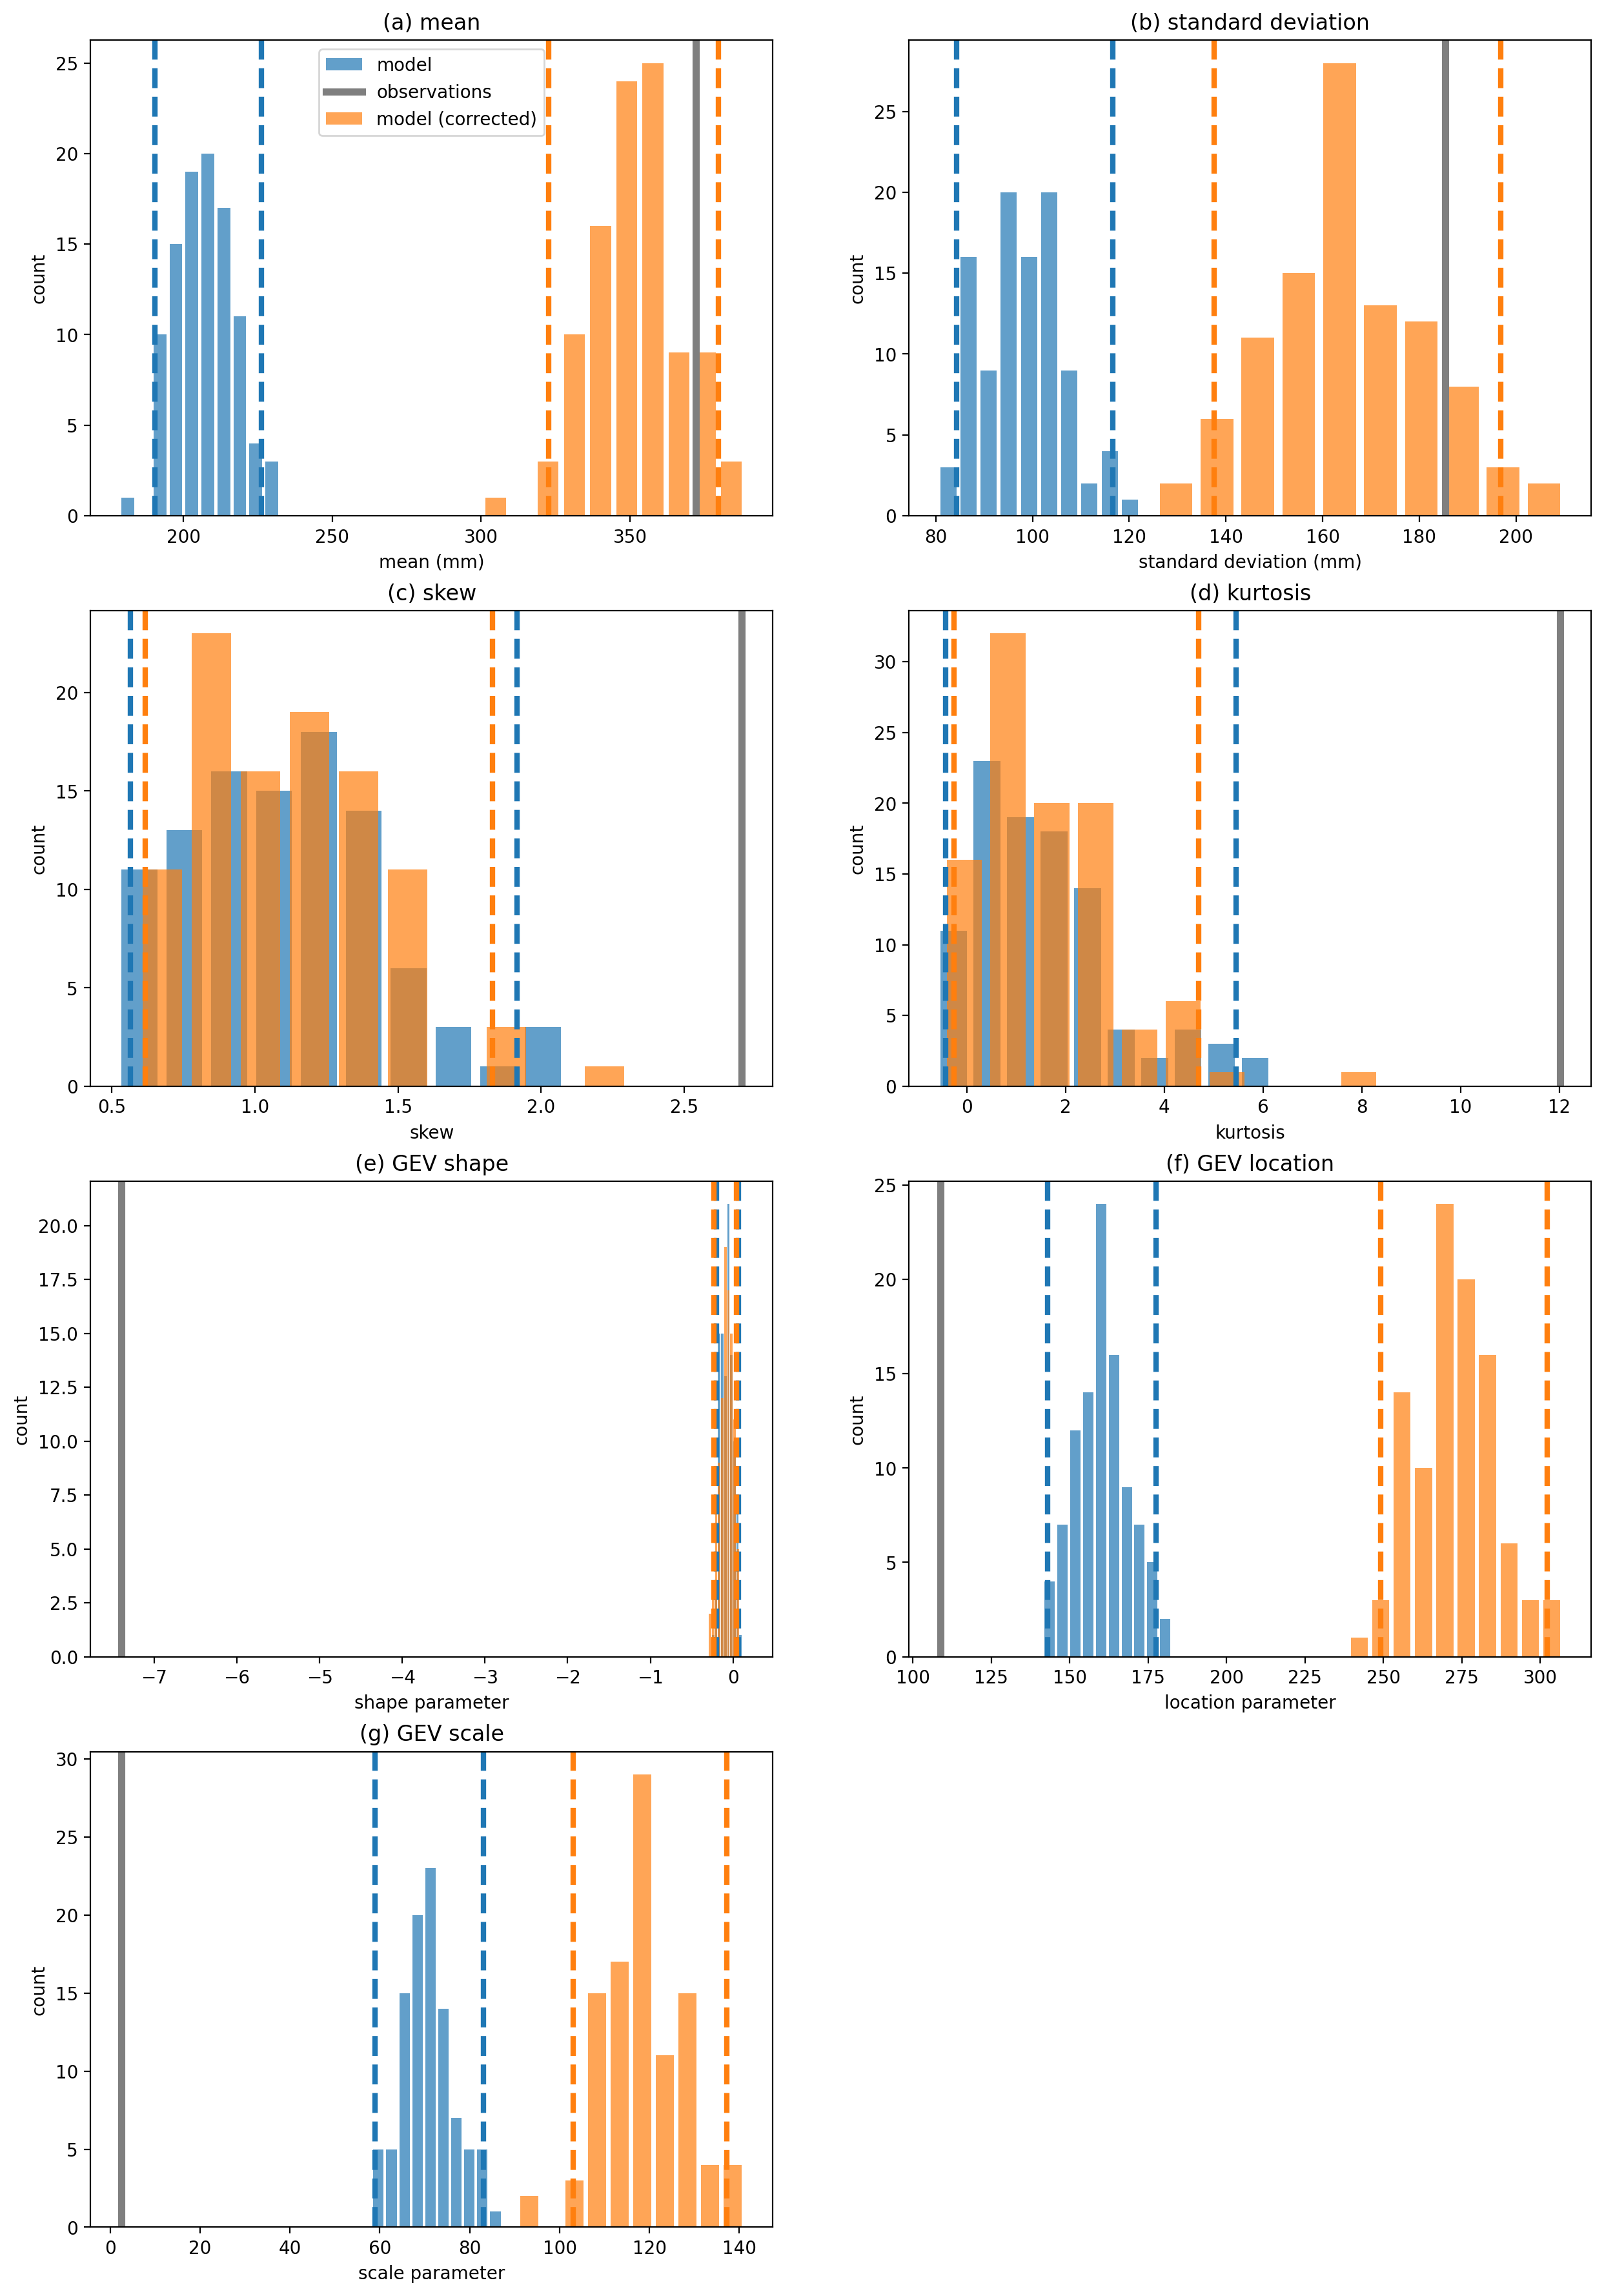

In [78]:
Image(filename=moments_mulc_plot)

### Return curves

In [79]:
def gev_event_likelihood(event, shape, loc, scale):
    """Get likelihood stats for an event from a GEV fit"""

    probability = gev.sf(event, shape, loc=loc, scale=scale)
    return_period = 1. / probability
    percentile = (1 - probability) * 100
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period\n')

#### Additive bias corrected data

In [81]:
n_events_add_bc, n_population_add_bc, return_period_add_bc, percentile_add_bc = eva.event_in_context(
    model_add_bc_da_stacked.values,
    obs_max_event,
    'above',
)
print('ADDITIVE BIAS CORRECTED DATA')
print(f'{n_events_add_bc} events in {n_population_add_bc} samples')
print(f'{percentile_add_bc:.2f}% percentile')
print(f'{return_period_add_bc:.0f} year return period')

ADDITIVE BIAS CORRECTED DATA
0 events in 10260 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/eva.py:44: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


In [83]:
print('ADDITIVE BIAS CORRECTED GEV')
gev_event_likelihood(obs_max_event, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)

ADDITIVE BIAS CORRECTED GEV
100.00% percentile
21120 year return period



#### Multiplicative bias corrected data

ValueError: tuple.index(x): x not in tuple

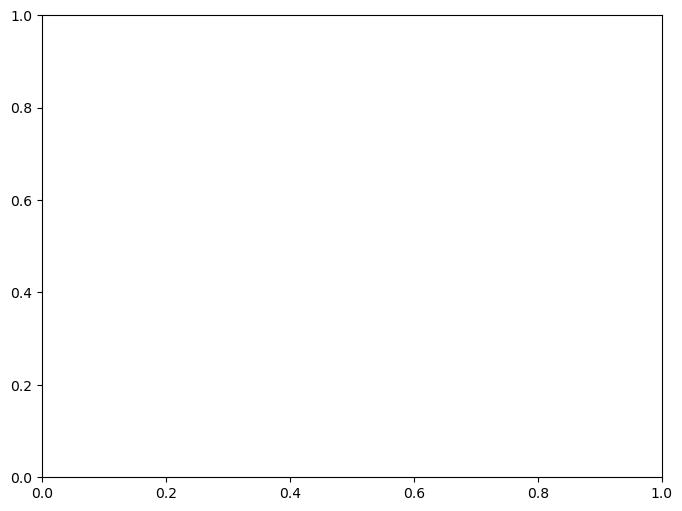

In [85]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
eva.plot_gev_return_curve(
    ax,
    model_mulc_bc_da_stacked,
    obs_max_event,
    bootstrap_method='non-parametric',
    n_bootstraps=1000,
    ylabel=metric_plot_label,
    ylim=[50, metric_plot_upper_limit],
    text=True,
)
#outfile = f'/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/{metric}_return-curve_{model_name}_{region_name}.png'
#print(outfile)
#plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [86]:
n_events_mulc_bc, n_population_mulc_bc, return_period_mulc_bc, percentile_mulc_bc = eva.event_in_context(model_add_bc_da_stacked.values, obs_max_event, 'above')
print('MULTIPLICATIVE BIAS CORRECTED DATA')
print(f'{n_events_mulc_bc} events in {n_population_mulc_bc} samples')
print(f'{percentile_mulc_bc:.2f}% percentile')
print(f'{return_period_mulc_bc:.0f} year return period')

MULTIPLICATIVE BIAS CORRECTED DATA
0 events in 10260 samples
100.00% percentile
inf year return period


In [87]:
print('MULTIPLICATIVE BIAS CORRECTED GEV')
gev_event_likelihood(obs_max_event, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)

MULTIPLICATIVE BIAS CORRECTED GEV
99.91% percentile
1130 year return period



#### Raw data

In [88]:
n_events, n_population, return_period, percentile = eva.event_in_context(model_da_stacked.values, obs_max_event, 'above')
print('RAW DATA')
print(f'{n_events} events in {n_population} samples')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
0 events in 10260 samples
100.00% percentile
inf year return period


In [89]:
print('RAW GEV')
gev_event_likelihood(obs_max_event, model_gev_shape, model_gev_loc, model_gev_scale)

RAW GEV
100.00% percentile
46187 year return period



### Seasonality

In [90]:
model_df = model_da_stacked.to_dataframe()
model_df = model_df.dropna()

In [91]:
event_months = [int(date[5:7]) for date in model_df['event_time'].values]
event_years = [int(date[0:4]) for date in model_df['event_time'].values]

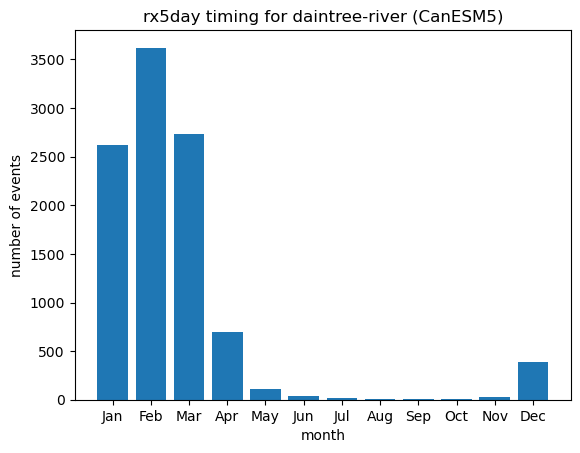

In [93]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'{metric} timing for {region_name} ({model_name})')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
#outfile = f'/g/data/xv83/unseen-projects/outputs/tc-jasper/figures/{metric}_timing_{model_name}_{region_name}.png'
#print(outfile)
#plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

### Meteorology

In [ ]:
def plot_average(start_date, end_date, color_da=None, color_var=None, contour_da=None, contour_var=None):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var:
        if color_var == 'pr':
            levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
            label = 'total precipitation (mm)'
            cmap = cmocean.cm.rain
            extend = 'max'
        elif color_var == 'ua300':
            levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
            label = '300hPa zonal wind'
            cmap='RdBu_r'
            extend = 'both'
        else:
            raise ValueError('Invalid color variable')
        color_da.plot(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            levels=levels,
            extend=extend,
            cbar_kwargs={'label': label},
        )
    
    if contour_var:
        if contour_var == 'z500':
            levels = np.arange(5000, 6300, 50)
        elif contour_var == 'psl':
            levels = np.arange(900, 1100, 2.5)
        elif contour_var == 'ua300':
            levels = np.arange(15, 60, 5)
        else:
            raise ValueError('Invalid contour variable')
        lines = contour_da.plot.contour(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    if contour_var:
        ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    else:
        ax1.set_title(f'{start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [ ]:
ranked_events = model_df.sort_values(by=['pr'], ascending=False)
ranked_events.head(n=10)

In [ ]:
model_add_bc_df = model_add_bc_ds['pr'].to_dataframe()
model_add_bc_df = model_add_bc_df.dropna()
model_add_bc_df = model_add_bc_df.reset_index()
ranked_add_bc_events = model_add_bc_df.sort_values(by=['pr'], ascending=False)
ranked_add_bc_events.head(n=10)

In [ ]:
model_mulc_bc_df = model_mulc_bc_ds['pr'].to_dataframe()
model_mulc_bc_df = model_mulc_bc_df.dropna()
model_mulc_bc_df = model_mulc_bc_df.reset_index()
ranked_mulc_bc_events = model_mulc_bc_df.sort_values(by=['pr'], ascending=False)
ranked_mulc_bc_events.head(n=10)

In [ ]:
for index, row in ranked_events.head(n=4).iterrows():
    init_date = int(row['init_date'].strftime('%Y')) - 1
    ensemble = int(row['ensemble']) + 1
    end_date = row['event_time']
    rx_value = row['pr']
    print(f'{init_date} ({end_date}), ensemble: r{ensemble}, {rx_value}mm')
    
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    
    pr_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/pr/*/*/*.nc')
    pr_files.sort()
    ds_pr = fileio.open_dataset(pr_files, variables=['pr'],)
    
    psl_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/psl/*/*/*.nc')
    psl_files.sort()
    ds_psl = fileio.open_dataset(psl_files, variables=['psl'],)
    
    zg_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/zg/*/*/*.nc')
    zg_files.sort()
    ds_zg = fileio.open_dataset(zg_files, variables=['zg'],)
    
    ua_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/ua/*/*/*.nc')
    ua_files.sort()
    ds_ua = fileio.open_dataset(ua_files, variables=['ua'],)

    pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')
    zg_da = ds_zg.sel({'time': slice(start_date, end_date)})['zg']
    z500_da = zg_da.sel({'plev': 50000}, method='nearest')
    ua_da = ds_ua.sel({'time': slice(start_date, end_date)})['ua']
    ua300_da = ua_da.sel({'plev': 30000}, method='nearest')

    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
    z500_da_mean = z500_da.mean('time', keep_attrs=True)
    ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

    plot_average(start_date, end_date, pr_da_sum, 'pr', psl_da_mean, 'psl')
    plot_average(start_date, end_date, pr_da_sum, 'pr', z500_da_mean, 'z500')
    plot_average(start_date, end_date, ua300_da_mean, 'ua300', z500_da_mean, 'z500')

In [ ]:
def plot_mslp(ax, title, pr_da, mslp_da):
    """Plot MSLP"""

    pr_da.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmocean.cm.rain,
        levels=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900],
        extend='max',
        cbar_kwargs={'label': 'total precipitation (mm)'},
    )
    lines = mslp_da.plot.contour(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=np.arange(900, 1100, 2.5),
        colors=['0.1']
    )
    ax.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax.coastlines()
    ax.set_extent([95, 195, -55, -5], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--', draw_labels=True)
    ax.set_title(title)

In [ ]:
fig = plt.figure(figsize=[10, 17])
map_proj=ccrs.PlateCarree(central_longitude=180)

plotnum = 1
for index, row in ranked_events.head(n=3).iterrows():
    ax = fig.add_subplot(3, 1, plotnum, projection=map_proj)
    
    init_date = int(row['init_date'].strftime('%Y')) - 1
    ensemble = int(row['ensemble']) + 1
    end_date = row['event_time']
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    title = f'{start_date} to {end_date} (initialisation: {init_date}, ensemble: {ensemble})'
    
    pr_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/pr/*/*/*.nc')
    pr_files.sort()
    ds_pr = fileio.open_dataset(pr_files, variables=['pr'],)
    
    psl_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/psl/*/*/*.nc')
    psl_files.sort()
    ds_psl = fileio.open_dataset(psl_files, variables=['psl'],)
    
    pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')

    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
    
    plot_mslp(ax, title, pr_da_sum, psl_da_mean)
    plotnum += 1

plt.savefig(
    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_top3_mslp-pr_{model_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=dpi
)
plt.show()

In [ ]:
fig = plt.figure(figsize=[10, 5])
map_proj=ccrs.PlateCarree(central_longitude=180)

plotnum = 1
for index, row in ranked_events.head(n=1).iterrows():
    ax = fig.add_subplot(1, 1, plotnum, projection=map_proj)
    
    init_date = int(row['init_date'].strftime('%Y')) - 1
    ensemble = int(row['ensemble']) + 1
    end_date = row['event_time']
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    title = f'{start_date} to {end_date} (initialisation: {init_date}, ensemble: {ensemble})'
    
    pr_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/pr/*/*/*.nc')
    pr_files.sort()
    ds_pr = fileio.open_dataset(pr_files, variables=['pr'],)
    
    psl_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/psl/*/*/*.nc')
    psl_files.sort()
    ds_psl = fileio.open_dataset(psl_files, variables=['psl'],)
    
    pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')

    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
    
    plot_mslp(ax, title, pr_da_sum, psl_da_mean)
    plotnum += 1

plt.savefig(
    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_top1_mslp-pr_{model_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=dpi
)
plt.show()